In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/toxic-classify/

/content/drive/MyDrive/toxic-classify


In [ ]:
#import cac thu vien can thiet

import pandas as pd
import spacy

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string
import pandas as pd

In [ ]:
#load du lieu dau vao
df = pd.read_csv("train.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [ ]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


# Phân tích bài toán


## 1. Mô tả bài toán

- Đây là một bài toán phân loại (học có giám sát) ứng dụng trong xử lý ngôn ngữ tự nhiên.

- Dữ liệu được cho là các câu insincere và sincere được thu thập trên mạng xã hội Quora.

- Đầu vào là một câu bất kỳ (tiếng Anh, dạng text), output là nhãn của câu đó trong phạm vi 0 hoặc 1). O tương ứng với nhãn Sincere, 1 tương ứng với nhãn Insincere 

## 2. Phân tích khám phá dữ liệu (Explore data analysis)

### 2. 1 Về tập dữ liệu

- Tập dữ liệu train.csv bao gồm các thuộc tính qid, question_text, target và 1306122 bản ghi.

- Do qid là duy nhất với từng câu nên thuộc tính này không quan trọng, trong nhiệm vụ này chúng ta chỉ quan tâm tới question_text (đầu vào bài toán) và target (output bài toán)

- Không có bất kỳ trường dữ liệu nào khuyết thiếu nên không cần xử lý missing data

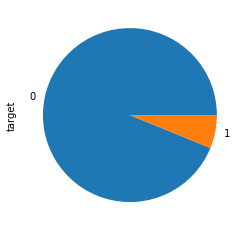

In [ ]:
#phan bo du lieu theo nhan
#bieu do hinh tron

df.target.value_counts().plot.pie()

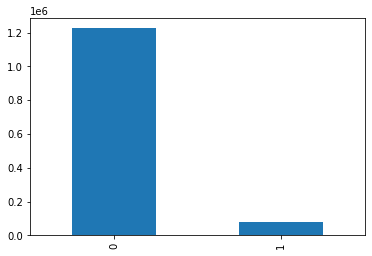

In [ ]:
#bieu do cot

df.target.value_counts().plot.bar()

- Nhận xét: dữ liệu đã cho là mất cân bằng nghiêm trọng, tỉ lệ nhãn 0 vô cùng lớn. Vì vậy không thể dùng thang đo Accuracy để đánh giá chất lượng mô hình

=> Sử dụng thang đo F1 score để đánh giá

# Mô hình hóa dữ liệu

## 1. Pipeline 

- Nhìn chung, bài toán này cũng như các bài toán Machine Learning cơ bản khác, đều có đường ống xử lý qua các bước như sau:

    - Step 1: Tiền xử lý (preprocessing):
        - đưa về dạng in thường
        - xóa các kí tự đặc biệt, thẻ html
        - tách từ (có thể có hoặc không), loại bỏ stopword
        - Lemmatizers: do tiếng Anh là ngôn ngữ biến hình, một từ có nhiều hình thái thể hiện (quá khứ, hiện tại: ví dụ do - done - did) nên cần đưa về dạng chung duy nhất

    - Step 2: Vectorize, vector hóa, đưa văn bản text thành biểu diễn tòan số. Do bài toán này em chỉ định áp dụng các mô hình học máy cổ điển nên chủ yếu sử dụng phương pháp Counvectizer (gần như onehot encoding) hoặc Tfidf (nâng cao thì có word2vec hoặc BERT).
        - Sử dụng CountVectorizer để trích xuất các từ, biến words thành dạng vectors ở dạng Bag-of-Words bằng cách đếm số lần xuất hiện của các từ trong bộ dữ liệu.
        - TF-IDF (Term Frequency – Inverse Document Frequency) là 1 kĩ thuật sử dụng trong khai phá dữ liệu văn bản. Trọng số này được sử dụng để đánh giá tầm quan trọng của một từ trong một văn bản. Giá trị cao thể hiện độ quan trọng cao và nó phụ thuộc vào số lần từ xuất hiện trong văn bản nhưng bù lại bởi tần suất của từ đó trong tập dữ liệu.

    
    - Step 3: Đưa qua mô hình học và lựa chọn tham số tối ưu (ở đây sử dụng mô hình dự kiến là svm và naivebayes)

## 2. Prepeocessing

# Mục mới

In [ ]:
#xoa cac ki tu dac biet
def clean_text(x):

    x = str(x).lower()
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

In [ ]:
df['question_text_clean'] = df['question_text'].apply(clean_text)

In [ ]:
df

,qid,question_text,target,question_text_clean
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,how did quebec nationalists see their province...
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,do you have an adopted dog how would you encou...
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,why does velocity affect time does velocity af...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,how did otto von guericke used the magdeburg h...
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,can i convert montra helicon d to a mountain b...
...,...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0,what other technical skills do you need as a c...
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0,does ms in ece have good job prospects in usa ...
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0,is foam insulation toxic
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0,how can one start a research project based on ...


## 3. Mô hình hóa

- Do không up lên kaggle nên không có dữ liệu test thử nghiệm. Vì vậy em thử nghiệm qua phương pháp sau: Chia tập dữ liệu thành 3 phần: train, dev, test:
    - Tập train: là dùng để huấn luyện mô hình (0.7)
    
    - Tập dev: tập lựa chọn tham số tối ưu cho mô hình (0.1)
    
    - Tập test: để đánh giá chất lượng mô hình (0.2)
    

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.question_text_clean.values, df.target.values, train_size=0.8, shuffle=True)

In [ ]:
X_train

array(['why do feminists want to make men have less rights',
       'as the next generation of voters comes of age how will it affect the current electoral map',
       'why do some people attempt to normalise gender dysphoria as something that is not a mental illness',
       ..., 'how much i can win in horse betting',
       'i slept with my daughter s babysitter while my wife was out and my daughter saw the whole thing what do i do',
       'if social media was outlawed what would be the positive and negative affects it would have'],
      dtype=object)

In [ ]:
X_test

array(['how can an entrepreneur apply to endeavor selection panel',
       'what are the elements of unjust enrichment',
       'is there any completely free virtual machine software for windows 10 32 bit',
       ..., 'what are subject for b sc computer science',
       'how can you draw the protist classification chart',
       'are there any good coding games for android'], dtype=object)

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, train_size=0.875)

In [ ]:
X_train

array(['how do you change your profile picture on a phone',
       'what is the most popular name for an american',
       'how do you say the chinese phase 为什么说… in engilsh what is the subject',
       ...,
       'what are some interesting psychological facts that needs to be shared',
       'how has the broken windows theory influenced william bratton s policing style',
       'what are some good topics for debate on economical issues'],
      dtype=object)

In [ ]:
X_dev

array(['how long and when should i wash my head with cold water',
       'how many days does it take to be cured from chicken pox',
       'what is the best way to find clients for instagram growth services',
       ..., 'why do brahmins love their own community more than india',
       'do americans actually prefer people with crude manner over people with refined manner',
       'what are the algorithms used for common subexpression elimination'],
      dtype=object)

In [ ]:
transformer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.5)

In [ ]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)
X_dev = transformer.transform(X_dev)

In [ ]:
linear_svm = LinearSVC(C=1.0)

In [ ]:
X_train

949495     will i make it as a singer if i don t have a v...
1290936    what s are some awesome exercises for building...
381556     who is at fault if two cars move into the same...
868737     what is the best way to market and promote alt...
582966     what is the most suitable type of chair for wo...
                                 ...                        
161777                     what if i don t want a girlfriend
1197087    why do so many london convertible owners drive...
538161     why dont north indians accept that south india...
1000086    is low percentage in graduation is a disadvant...
984918                 who writes the answer wikis for quora
Name: question_text_clean, Length: 914284, dtype: object

In [ ]:
#Thử train với linear svm với tham số C bất kỳ
linear_svm.fit(X_train, y_train)

LinearSVC()

In [ ]:
#Infer dữ liệu test 
y_pred = linear_svm.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98    245067
           1       0.67      0.55      0.60     16158

    accuracy                           0.96    261225
   macro avg       0.82      0.76      0.79    261225
weighted avg       0.95      0.96      0.95    261225



In [ ]:
#Tìm kiếm tham số C cho mô hình svm
c = 0.1
while c <= 1.5:
  linear_svm = LinearSVC(C=c)
  linear_svm.fit(X_train, y_train)
  y_pred = linear_svm.predict(X_dev)
  print(f"C = {c}")
  print(classification_report(y_dev, y_pred, labels=[0, 1]))
  c += 0.1

C = 0.1
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    122505
           1       0.73      0.44      0.54      8108

    accuracy                           0.95    130613
   macro avg       0.84      0.71      0.76    130613
weighted avg       0.95      0.95      0.95    130613

C = 0.2
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    122505
           1       0.71      0.48      0.58      8108

    accuracy                           0.96    130613
   macro avg       0.84      0.73      0.78    130613
weighted avg       0.95      0.96      0.95    130613

C = 0.30000000000000004
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    122505
           1       0.71      0.51      0.59      8108

    accuracy                           0.96    130613
   macro avg       0.84      0.75      0.78    130613
weighted avg       0.95      0.96 

- Nhận xét: khi tham số C thay đổi thì F1 score cũng như Accuracy không thay đổi nhiều lắm, vì vậy khi heristic tìm tham số tối ưu ở C không có nhiều ý nghĩa 

=> chuyển sang thay đổi các parameter ở transformer

> Indented block



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.question_text_clean.values, df.target.values, train_size=0.8, shuffle=True)

In [ ]:
#Tìm kiếm tham số tối ưu max_df cho Tfidf transform
max_df = 0.1
while max_df <= 1:
  linear_svm = LinearSVC(C=c)
  transformer = TfidfVectorizer(ngram_range=(1, 2), max_df=max_df)
  X_train_transform = transformer.fit_transform(X_train)
  X_dev_transform = transformer.transform(X_dev)
  linear_svm.fit(X_train_transform, y_train)
  y_pred = linear_svm.predict(X_dev_transform)
  max_df += 0.1
  print(f"max_df: {max_df}")
  print(classification_report(y_dev, y_pred, labels=[0, 1]))

max_df: 0.2
              precision    recall  f1-score   support

           0       0.97      0.98      0.98    122518
           1       0.66      0.55      0.60      8095

    accuracy                           0.95    130613
   macro avg       0.81      0.77      0.79    130613
weighted avg       0.95      0.95      0.95    130613

max_df: 0.30000000000000004
              precision    recall  f1-score   support

           0       0.97      0.98      0.98    122518
           1       0.66      0.55      0.60      8095

    accuracy                           0.95    130613
   macro avg       0.81      0.77      0.79    130613
weighted avg       0.95      0.95      0.95    130613

max_df: 0.4
              precision    recall  f1-score   support

           0       0.97      0.98      0.98    122518
           1       0.66      0.55      0.60      8095

    accuracy                           0.95    130613
   macro avg       0.81      0.77      0.79    130613
weighted avg       0.9

KeyboardInterrupt: ignored

- Nhận xét: khi giới hạn max_df để giới hạn số lượng từ trong từ điển thì các các thang đó không thay đổi quá nhiều
=> tiếp tục thử với dải ngram

In [ ]:
linear_svm = LinearSVC()
transformer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.7)
X_train_transform = transformer.fit_transform(X_train)
X_dev_transform = transformer.transform(X_dev)
linear_svm.fit(X_train_transform, y_train)
y_pred = linear_svm.predict(X_dev_transform)
print(f"max_df: {max_df}")
print(classification_report(y_dev, y_pred, labels=[0, 1]))

max_df: 0.7999999999999999
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    122518
           1       0.63      0.64      0.63      8095

    accuracy                           0.95    130613
   macro avg       0.80      0.81      0.80    130613
weighted avg       0.95      0.95      0.95    130613



In [ ]:
linear_svm = LinearSVC()
transformer = TfidfVectorizer(ngram_range=(1, 4), max_df=0.7)
X_train_transform = transformer.fit_transform(X_train)
X_dev_transform = transformer.transform(X_dev)
linear_svm.fit(X_train_transform, y_train)
y_pred = linear_svm.predict(X_dev_transform)
print(f"max_df: {max_df}")
print(classification_report(y_dev, y_pred, labels=[0, 1]))

max_df: 0.7999999999999999
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    122518
           1       0.59      0.70      0.64      8095

    accuracy                           0.95    130613
   macro avg       0.79      0.84      0.81    130613
weighted avg       0.96      0.95      0.95    130613



In [ ]:
X_test_transform = transformer.transform(X_test)
y_pred = linear_svm.predict(X_test_transform)
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97    245218
           1       0.58      0.70      0.63     16007

    accuracy                           0.95    261225
   macro avg       0.78      0.83      0.80    261225
weighted avg       0.96      0.95      0.95    261225



In [ ]:
X_test

array(['is donald trump going to be thrown out of the country like benedict arnold',
       'what are the best tips for building a strong and great team',
       'does it make sense to try and do a ms in ai or cs if my bahcelors degree was in finance stats',
       ..., 'how do i get seed funding for my start up',
       'what happen if hit myself to mjolnir at 80 miles per hour',
       'what should i do if my partner is a lesbian'], dtype=object)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
transformer = TfidfVectorizer(ngram_range=(1, 4), max_df=0.7)
X_train_transform = transformer.fit_transform(X_train)
X_dev_transform = transformer.transform(X_dev)

alpha = 0.1
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    122450
           1       0.77      0.14      0.23      8163

    accuracy                           0.94    130613
   macro avg       0.86      0.57      0.60    130613
weighted avg       0.93      0.94      0.92    130613

alpha = 0.2
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    122450
           1       0.83      0.04      0.08      8163

    accuracy                           0.94    130613
   macro avg       0.89      0.52      0.52    130613
weighted avg       0.93      0.94      0.91    130613

alpha = 0.30000000000000004
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    122450
           1       0.81      0.02      0.03      8163

    accuracy                           0.94    130613
   macro avg       0.87      0.51      0.50    130613
weighted avg       0.9

KeyboardInterrupt: ignored

In [ ]:
a = 0.001
while a <= 0.02:
  model = MultinomialNB(alpha=a)
  model.fit(X_train_transform, y_train)
  y_pred = model.predict(X_dev_transform)
  print(f"alpha = {a}")
  print(classification_report(y_dev, y_pred, labels=[0, 1]))
  a += 0.001

alpha = 0.001
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    122450
           1       0.54      0.52      0.53      8163

    accuracy                           0.94    130613
   macro avg       0.76      0.75      0.75    130613
weighted avg       0.94      0.94      0.94    130613

alpha = 0.002
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    122450
           1       0.54      0.54      0.54      8163

    accuracy                           0.94    130613
   macro avg       0.76      0.76      0.76    130613
weighted avg       0.94      0.94      0.94    130613

alpha = 0.003
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    122450
           1       0.55      0.55      0.55      8163

    accuracy                           0.94    130613
   macro avg       0.76      0.76      0.76    130613
weighted avg       0.94      0.9

Chọn alpha = 0.01

In [ ]:
X_test_transform = transformer.transform(X_test)

model = MultinomialNB(alpha=0.01)
model.fit(X_train_transform, y_train)
y_pred = model.predict(X_test_transform)
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    245202
           1       0.58      0.54      0.56     16023

    accuracy                           0.95    261225
   macro avg       0.77      0.76      0.77    261225
weighted avg       0.95      0.95      0.95    261225

